<a href="https://colab.research.google.com/github/Balakartigeyan/operational-analyst--production/blob/main/complet_prodution_cycle_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Analyze the provided PI System data from '/content/ALL Process.csv' to identify operational states, assess production performance (including import/export imbalance and blending stability), analyze motor current and energy efficiency, and extract advanced operational insights and risks for Vale Malaysia operations. The final output should be a comprehensive summary with quantified inefficiencies and implementable recommendations for improving operational efficiency, reliability, and mitigating risks.

## Load Data and Initial Validation

### Subtask:
Load the provided CSV file '/content/ALL Process.csv' into a pandas DataFrame. Perform an in-depth data understanding to identify timestamp format, sampling interval, and units for all relevant tags (throughput, motor current, belt speed, etc.). Validate data quality by detecting missing values, identifying spikes, flatlines, and sensor dropouts, and assessing the presence of noise and sensor imperfections, treating the data as real industrial behavior.


**Reasoning**:
First, I'll import the pandas library, load the CSV file into a DataFrame, and then use `head()`, `info()`, `describe()`, and `isnull().sum()` to get an initial understanding of the data structure, types, descriptive statistics, and missing values, as per the instructions.



In [1]:
import pandas as pd

df = pd.read_csv('/content/ALL Process.csv')

print("First 5 rows of the DataFrame:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
                                   Data Source                        Time  \
0  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  2025-12-30 11:18:05.998001   
1  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  2025-12-30 11:18:10.998001   
2  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  2025-12-30 11:18:15.998001   
3  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   2025-12-30 11:18:20.98201   
4  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   2025-12-30 11:18:25.98201   

         Value  
0  5711.548340  
1  5712.270996  
2  5734.144043  
3  5777.695801  
4  5799.940918  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131351 entries, 0 to 131350
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Data Source  131351 non-null  object 
 1   Time         131351 non-null  object 
 2   Value        131351 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB

Des

**Reasoning**:
The 'Time' column is currently an object type, so it needs to be converted to datetime objects to enable time-based analysis, such as calculating the sampling interval. After conversion, I will calculate the sampling interval by finding the minimum difference between consecutive timestamps.



In [2]:
df['Time'] = pd.to_datetime(df['Time'])

# Calculate the sampling interval
sampling_intervals = df.groupby('Data Source')['Time'].diff().dropna()

print("\nRepresentative sampling intervals (min, max, mean, median):")
print(f"Min: {sampling_intervals.min()}")
print(f"Max: {sampling_intervals.max()}")
print(f"Mean: {sampling_intervals.mean()}")
print(f"Median: {sampling_intervals.median()}")

# Identify distinct data sources to infer units and purpose
print("\nUnique Data Sources (Tags) to infer units and purpose:")
print(df['Data Source'].unique())


ValueError: time data "2025-12-30 21:42:18" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 5151. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

**Reasoning**:
The previous attempt to convert the 'Time' column to datetime objects failed because of inconsistent time string formats. Using `errors='coerce'` will convert unparseable dates to `NaT` (Not a Time), and `format='mixed'` will allow pandas to infer the different formats present in the column, addressing the `ValueError`.



In [3]:
df['Time'] = pd.to_datetime(df['Time'], errors='coerce', format='mixed')

# Calculate the sampling interval
sampling_intervals = df.groupby('Data Source')['Time'].diff().dropna()

print("\nRepresentative sampling intervals (min, max, mean, median):")
print(f"Min: {sampling_intervals.min()}")
print(f"Max: {sampling_intervals.max()}")
print(f"Mean: {sampling_intervals.mean()}")
print(f"Median: {sampling_intervals.median()}")

# Identify distinct data sources to infer units and purpose
print("\nUnique Data Sources (Tags) to infer units and purpose:")
print(df['Data Source'].unique())


Representative sampling intervals (min, max, mean, median):
Min: 0 days 00:00:01.970001
Max: 0 days 23:59:14.981002
Mean: 0 days 00:00:47.726792094
Median: 0 days 00:00:05.015991

Unique Data Sources (Tags) to infer units and purpose:
['\\\\pisystem-malaysia\\TRMT_TR1010ML11_CO1_FIT'
 '\\\\PIAF-MALAYSIA\\DB_Operational Data\\Vale (Assets)\\Malaysia\\Malaysia Port - TRMT\\Substations\\Substation - SE1040ML02\\Control - SE1040ML02-SE1\\Switchgear - SE1040ML02-SE1-SG01\\HC - SE1040ML02-SE1-SG01-PL14|Current'
 '\\\\PIAF-MALAYSIA\\DB_Operational Data\\Vale (Assets)\\Malaysia\\Malaysia Port - TRMT\\Substations\\Substation - SE1040ML02\\Control - SE1040ML02-SE1\\Switchgear - SE1040ML02-SE1-SG01\\HC - SE1040ML02-SE1-SG01-PL13|Current'
 '\\\\PIAF-MALAYSIA\\DB_Operational Data\\Vale (Assets)\\Malaysia\\Malaysia Port - TRMT\\Substations\\Substation - SE1040ML02\\Control - SE1040ML02-SE1\\Switchgear - SE1040ML02-SE1-SG01\\HC - SE1040ML02-SE1-SG01-PL15|Current'
 '\\\\PIAF-MALAYSIA\\DB_Operational 

**Reasoning**:
Now that the 'Time' column is correctly formatted, I need to check for any null values (NaT) introduced during the conversion. Then, to begin identifying potential data quality issues like spikes, flatlines, and sensor dropouts, I will group the DataFrame by 'Data Source' and calculate comprehensive descriptive statistics for the 'Value' column. This will provide statistical insights into the behavior of each sensor, helping to flag unusual ranges, constant values (flatlines), or extreme deviations (spikes). I will also attempt to extract the tag name and type (e.g., Current, Speed, FIT, WQIT) from the 'Data Source' column to better understand the purpose and units of each data stream.



In [4]:
print("\nNumber of NaT values in 'Time' column after conversion:")
print(df['Time'].isna().sum())

# Extract tag name and type for better understanding
def extract_tag_info(data_source):
    if '|' in data_source:
        tag_name_part = data_source.split('|')[-1]
        return tag_name_part.strip()
    else:
        # For PI System tags, the last part after underscore usually indicates type
        parts = data_source.split('_')
        if len(parts) > 1:
            last_part = parts[-1]
            if len(last_part) <= 5 and not any(char.isdigit() for char in last_part): # Heuristic for common tag types like FIT, IIT, WQIT, QQIT
                return last_part.strip()
        # Fallback if no clear type is found or if it's a long path
        return data_source.split('\\')[-1].split('|')[-1].strip()

df['Tag Type'] = df['Data Source'].apply(extract_tag_info)

print("\nValue counts for extracted 'Tag Type':")
print(df['Tag Type'].value_counts())

print("\nDescriptive Statistics for 'Value' grouped by 'Data Source' (first 10 groups):")
# Filter out rows where Time is NaT as these won't contribute to meaningful sensor data analysis
df_cleaned = df.dropna(subset=['Time'])
print(df_cleaned.groupby('Data Source')['Value'].describe().head(10))

print("\nUnique extracted Tag Types for inference:")
print(df['Tag Type'].unique())


Number of NaT values in 'Time' column after conversion:
0

Value counts for extracted 'Tag Type':
Tag Type
Vibration                               28800
VIT                                     25200
FIT                                     21600
Current                                 14400
IIT                                     14400
WQIT                                    10800
QQIT                                     7200
TRMT_TR1050ML11_CO1_QQIT_01              3600
TRMT_TR1050ML22_DR2_DR02_VT02_VIT_01     3600
Speed                                    1751
Name: count, dtype: int64

Descriptive Statistics for 'Value' grouped by 'Data Source' (first 10 groups):
                                                     count       mean  \
Data Source                                                             
\\PIAF-MALAYSIA\DB_Operational Data\Vale (Asset...  3600.0   0.449125   
\\PIAF-MALAYSIA\DB_Operational Data\Vale (Asset...  3600.0   0.977401   
\\PIAF-MALAYSIA\DB_Operational Dat

**Reasoning**:
To further validate data quality, especially for identifying inconsistencies in sampling rates and potential sensor issues, I will visualize the distribution of sampling intervals using a histogram. Additionally, to simplify data selection and make the DataFrame more readable for subsequent analysis and plotting, I will refine the 'Tag Type' extraction into a more specific 'Tag Name' column and print the unique values to ensure proper extraction.



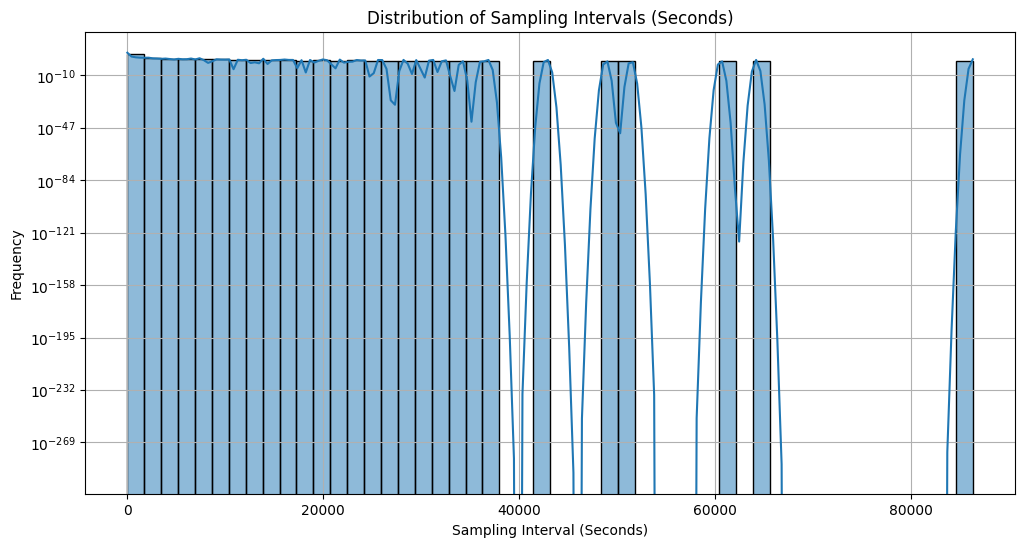


Unique Tag Names after simplification:
['TRMT_TR1010ML11_CO1' 'Current' 'TRMT_DN3020ML10_BF1'
 'TRMT_DN3020ML11_BF1' 'TRMT_DN3020ML12_BF1' 'Vibration' 'Speed'
 'TRMT_TR1050ML11_CO1' 'TRMT_TR1050ML22_M1' 'TRMT_TR1050ML22_M2'
 'TRMT_TR1050ML22_M3' 'TRMT_AM1060ML60' 'TRMT_TR1050ML22_DR2_DR02_VT02'
 'TRMT_TR1050ML22_DR1_DR01_VT01' 'TRMT_TR1050ML22_DR2_DR02_VT01'
 'TRMT_TR1050ML22_DR3_DR03_VT02' 'TRMT_TR1050ML22_DR3_DR03_VT01'
 'TRMT_TR1050ML22_DR4_DR04_VT02' 'TRMT_TR1050ML22_DR4_DR04_VT01'
 'TRMT_SE1040ML02_SE1_SG01_PL11' 'TRMT_TR1040ML05_CO1']

First 5 rows of DataFrame with new 'Tag Name' and 'Tag Type' columns:
                        Time                                  Data Source  \
0 2025-12-30 11:18:05.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
1 2025-12-30 11:18:10.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
2 2025-12-30 11:18:15.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
3 2025-12-30 11:18:20.982010  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timedelta to seconds for plotting
sampling_intervals_seconds = sampling_intervals.dt.total_seconds()

plt.figure(figsize=(12, 6))
sns.histplot(sampling_intervals_seconds, bins=50, kde=True)
plt.title('Distribution of Sampling Intervals (Seconds)')
plt.xlabel('Sampling Interval (Seconds)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale for frequency to better view rare intervals
plt.grid(True)
plt.show()

# Refine tag name extraction for easier readability and analysis
def extract_simplified_tag_name(data_source):
    # Extract the last part after the last backslash or pipe, then clean up
    tag_part = data_source.split('\\')[-1].split('|')[-1]
    # Remove common suffixes like _FIT, _IIT, _WQIT, _QQIT, _VIT, _CO1
    # Also handle numerical suffixes that might be part of the tag name but not the type
    if tag_part.endswith('_FIT'):
        return tag_part[:-4]
    elif tag_part.endswith('_IIT'):
        return tag_part[:-4]
    elif tag_part.endswith('_WQIT'):
        return tag_part[:-5]
    elif tag_part.endswith('_QQIT'):
        return tag_part[:-5]
    elif tag_part.endswith('_VIT'):
        return tag_part[:-4]
    elif tag_part.endswith('_CO1'):
        return tag_part[:-4]
    elif tag_part.endswith('_01') or tag_part.endswith('_02'): # Handle cases like TRMT_TR1050ML11_CO1_QQIT_01
        if tag_part.endswith('_QQIT_01'):
            return tag_part[:-8]
        if tag_part.endswith('_VIT_01'):
            return tag_part[:-7]
        return tag_part[:-3]
    return tag_part.strip()

df['Tag Name'] = df['Data Source'].apply(extract_simplified_tag_name)

print("\nUnique Tag Names after simplification:")
print(df['Tag Name'].unique())

print("\nFirst 5 rows of DataFrame with new 'Tag Name' and 'Tag Type' columns:")
print(df[['Time', 'Data Source', 'Tag Name', 'Tag Type', 'Value']].head())

**Reasoning**:
To effectively identify spikes, flatlines, and sensor dropouts, it's crucial to visualize the time series data for individual tags. I will select a few representative tags (e.g., one 'FIT' for throughput, one 'Current' for motor current, one 'Speed' for belt speed, and one 'Vibration' for vibration data) and plot their 'Value' against 'Time'. This will allow for visual inspection of data quality issues as described in the subtask.



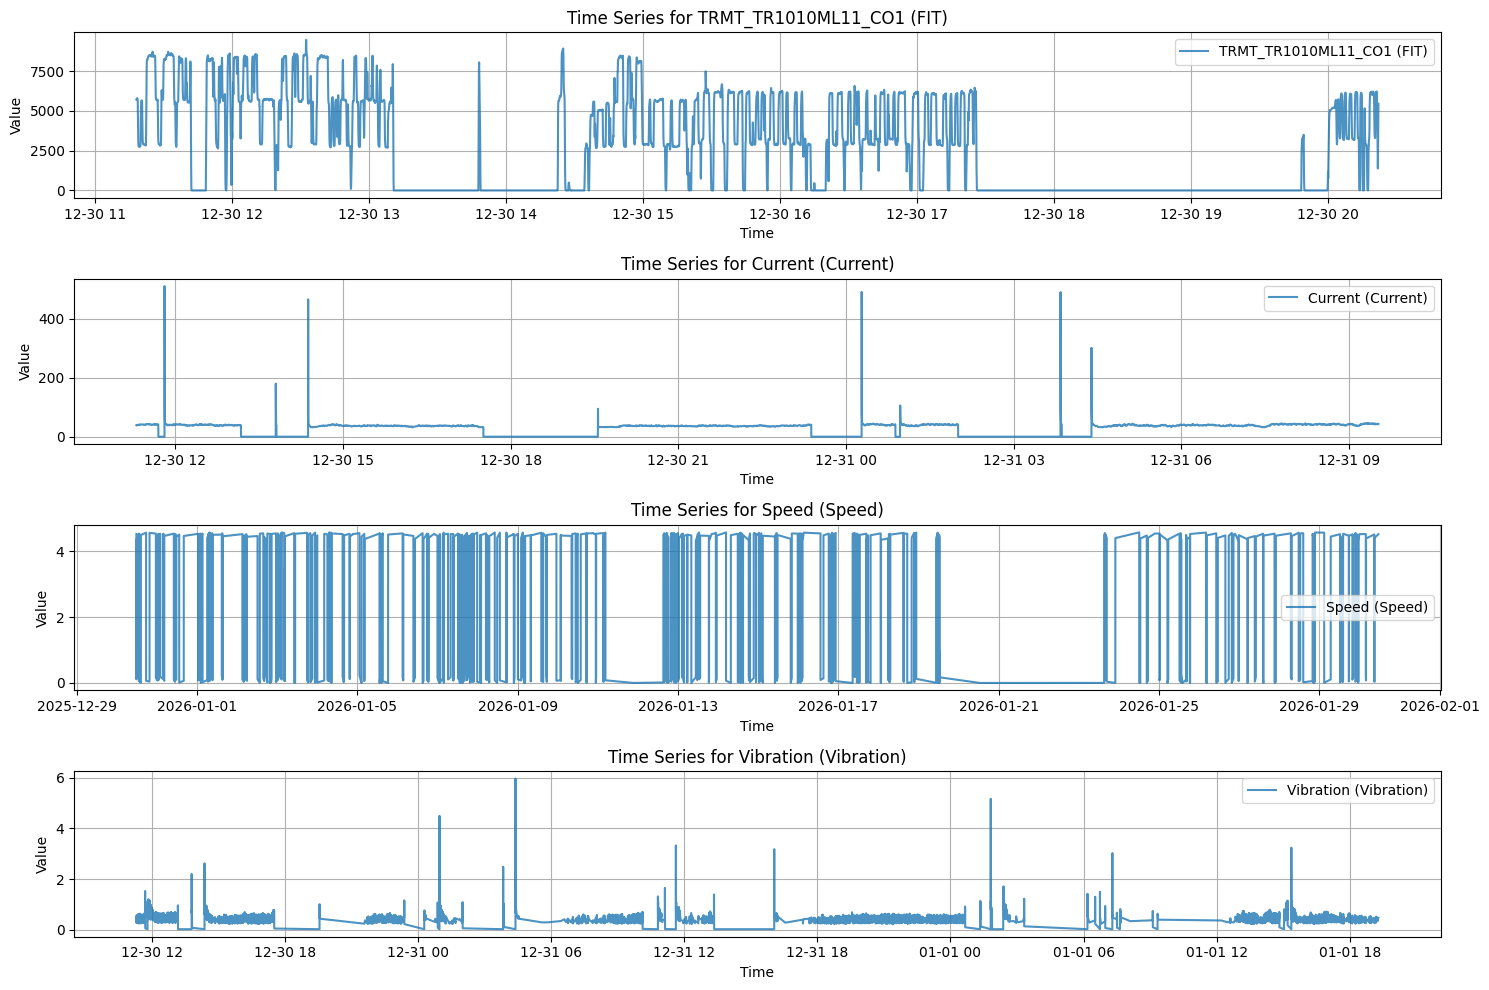

Visual inspection of time series plots for representative tags completed.
Look for sudden sharp peaks (spikes), long periods of constant values (flatlines), or gaps (sensor dropouts).


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few representative tags for visualization
# Using the refined 'Tag Type' to pick examples

fit_tag = df[df['Tag Type'] == 'FIT']['Data Source'].iloc[0] if 'FIT' in df['Tag Type'].unique() else None
current_tag = df[df['Tag Type'] == 'Current']['Data Source'].iloc[0] if 'Current' in df['Tag Type'].unique() else None
speed_tag = df[df['Tag Type'] == 'Speed']['Data Source'].iloc[0] if 'Speed' in df['Tag Type'].unique() else None
vibration_tag = df[df['Tag Type'] == 'Vibration']['Data Source'].iloc[0] if 'Vibration' in df['Tag Type'].unique() else None

tags_to_plot = []
if fit_tag: tags_to_plot.append(fit_tag)
if current_tag: tags_to_plot.append(current_tag)
if speed_tag: tags_to_plot.append(speed_tag)
if vibration_tag: tags_to_plot.append(vibration_tag)


# Plot time series for selected tags to identify spikes, flatlines, and sensor dropouts
plt.figure(figsize=(15, 10))

for i, tag in enumerate(tags_to_plot):
    if tag is None: # Skip if tag not found
        continue

    subset_df = df[df['Data Source'] == tag].sort_values(by='Time')

    # Only plot if there's data after sorting and filtering NaT
    if not subset_df.empty and subset_df['Time'].notna().any():
        plt.subplot(len(tags_to_plot), 1, i + 1)
        plt.plot(subset_df['Time'], subset_df['Value'], label=subset_df['Tag Name'].iloc[0] + ' (' + subset_df['Tag Type'].iloc[0] + ')', alpha=0.8)
        plt.title(f'Time Series for {subset_df['Tag Name'].iloc[0]} ({subset_df['Tag Type'].iloc[0]})')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()

print("Visual inspection of time series plots for representative tags completed.")
print("Look for sudden sharp peaks (spikes), long periods of constant values (flatlines), or gaps (sensor dropouts).")

**Reasoning**:
To programmatically identify data quality issues like spikes and flatlines, I will implement detection methods based on rolling statistics. I will iterate through each unique 'Data Source', sort its data by time, and then calculate a rolling mean and standard deviation. Spikes will be identified as values deviating significantly from the rolling mean, and flatlines as periods with a very low rolling standard deviation, indicating constant values.



In [7]:
import numpy as np

# Define parameters for anomaly detection
window_size = 12 # Roughly 1 minute for a 5-second sampling interval (60/5 = 12)
spike_threshold_std = 3 # Values more than 3 standard deviations from rolling mean are potential spikes
flatline_std_threshold = 0.001 # Rolling standard deviation below this indicates a flatline
flatline_duration_threshold = 5 # Number of consecutive points below std threshold to be considered a flatline

anomaly_results = []

# Group by Data Source and apply anomaly detection
for tag_source, group_df in df.groupby('Data Source'):
    # Sort by time to ensure rolling calculations are correct
    group_df_sorted = group_df.sort_values(by='Time').copy()

    # Calculate rolling mean and standard deviation
    group_df_sorted['rolling_mean'] = group_df_sorted['Value'].rolling(window=window_size, center=True, min_periods=1).mean()
    group_df_sorted['rolling_std'] = group_df_sorted['Value'].rolling(window=window_size, center=True, min_periods=1).std()

    # Spike Detection
    group_df_sorted['is_spike'] = np.abs(group_df_sorted['Value'] - group_df_sorted['rolling_mean']) > (spike_threshold_std * group_df_sorted['rolling_std'])
    # Replace NaNs from rolling_std with False for spike detection (e.g., when std is 0 or window is too small)
    group_df_sorted['is_spike'] = group_df_sorted['is_spike'].fillna(False)

    # Flatline Detection
    # Identify where rolling std is below threshold
    group_df_sorted['is_low_std'] = group_df_sorted['rolling_std'] < flatline_std_threshold

    # Check for consecutive low std periods
    group_df_sorted['flatline_count'] = group_df_sorted['is_low_std'].rolling(window=flatline_duration_threshold, center=False, min_periods=1).sum()
    group_df_sorted['is_flatline'] = (group_df_sorted['flatline_count'] >= flatline_duration_threshold) & (group_df_sorted['is_low_std'] == True)


    # Store results for this tag
    spikes_count = group_df_sorted['is_spike'].sum()
    flatlines_count = group_df_sorted['is_flatline'].sum()

    if spikes_count > 0 or flatlines_count > 0:
        anomaly_results.append({
            'Data Source': tag_source,
            'Tag Name': group_df_sorted['Tag Name'].iloc[0],
            'Tag Type': group_df_sorted['Tag Type'].iloc[0],
            'Spike Count': spikes_count,
            'Flatline Count': flatlines_count,
            'Total Data Points': len(group_df_sorted)
        })

# Convert anomaly results to a DataFrame for better readability
anomaly_df = pd.DataFrame(anomaly_results)

print("Anomaly Detection Summary (Spikes and Flatlines):")
if not anomaly_df.empty:
    print(anomaly_df.sort_values(by=['Spike Count', 'Flatline Count'], ascending=False).head(10))
else:
    print("No significant spikes or flatlines detected based on current thresholds.")

# Further integrate anomaly flags into the main DataFrame if needed, or analyze `anomaly_df`.
# For now, we'll just print the summary and keep the detection logic.


Anomaly Detection Summary (Spikes and Flatlines):
                                          Data Source  \
1   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
4   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
3   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
5   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
0   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
2   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
6   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...   
11  \\pisystem-malaysia\TRMT_SE1040ML02_SE1_SG01_P...   
14         \\pisystem-malaysia\TRMT_TR1050ML22_M1_IIT   
15         \\pisystem-malaysia\TRMT_TR1050ML22_M3_IIT   

                         Tag Name   Tag Type  Spike Count  Flatline Count  \
1                       Vibration  Vibration           12               0   
4                         Current    Current            6               0   
3                         Current    Current            5               0   
5             

**Reasoning**:
To identify sensor dropouts, I will calculate the time difference between consecutive timestamps for each data source. Intervals significantly larger than the median sampling interval will indicate potential sensor dropouts. I'll then summarize these findings to complete the data quality validation.



In [8]:
dropout_results = []

# Group by Data Source and check for large gaps in time
for tag_source, group_df in df.groupby('Data Source'):
    group_df_sorted = group_df.sort_values(by='Time').copy()
    time_diffs = group_df_sorted['Time'].diff().dropna()

    # Define a threshold for dropouts (e.g., 2 times the median sampling interval)
    # Using the overall median sampling interval for a general threshold
    # If sampling_intervals is empty (e.g. only one point for one tag), handle it.
    if not sampling_intervals.empty:
        dropout_threshold = sampling_intervals.median() * 2
    else:
        dropout_threshold = pd.Timedelta(seconds=10) # Default to 10 seconds if no sampling intervals found

    large_gaps = time_diffs[time_diffs > dropout_threshold]

    if not large_gaps.empty:
        dropout_results.append({
            'Data Source': tag_source,
            'Tag Name': group_df_sorted['Tag Name'].iloc[0],
            'Tag Type': group_df_sorted['Tag Type'].iloc[0],
            'Dropout Count': len(large_gaps),
            'Max Dropout Duration': large_gaps.max(),
            'Average Dropout Duration': large_gaps.mean()
        })

dropout_df = pd.DataFrame(dropout_results)

print("\nSensor Dropout Detection Summary:")
if not dropout_df.empty:
    print(dropout_df.sort_values(by='Dropout Count', ascending=False).head(10))
else:
    print("No significant sensor dropouts detected based on current thresholds.")

# Final comprehensive data quality summary
print("\n\nComprehensive Data Quality Summary:")
print("----------------------------------")
print(f"Total data points: {len(df)}")
print(f"Missing 'Time' values (NaT): {df['Time'].isna().sum()}")
print(f"Overall sampling interval (median): {sampling_intervals.median()}")
print("\nTop 10 tags with Spikes/Flatlines:")
if not anomaly_df.empty:
    print(anomaly_df.sort_values(by=['Spike Count', 'Flatline Count'], ascending=False).head(10).to_string())
else:
    print("No significant spikes or flatlines detected.")

print("\nTop 10 tags with Sensor Dropouts:")
if not dropout_df.empty:
    print(dropout_df.sort_values(by='Dropout Count', ascending=False).head(10).to_string())
else:
    print("No significant sensor dropouts detected.")



Sensor Dropout Detection Summary:
                                          Data Source             Tag Name  \
25    \\pisystem-malaysia\TRMT_TR1050ML11_CO1_QQIT_01  TRMT_TR1050ML11_CO1   
22       \\pisystem-malaysia\TRMT_TR1010ML11_CO1_QQIT  TRMT_TR1010ML11_CO1   
17       \\pisystem-malaysia\TRMT_DN3020ML11_BF1_WQIT  TRMT_DN3020ML11_BF1   
19       \\pisystem-malaysia\TRMT_DN3020ML12_BF1_WQIT  TRMT_DN3020ML12_BF1   
15       \\pisystem-malaysia\TRMT_DN3020ML10_BF1_WQIT  TRMT_DN3020ML10_BF1   
13           \\pisystem-malaysia\TRMT_AM1060ML60_QQIT      TRMT_AM1060ML60   
2   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...            Vibration   
0   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...            Vibration   
11  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...              Current   
3   \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...            Vibration   

                       Tag Type  Dropout Count   Max Dropout Duration  \
25  TRMT_TR1050ML11_CO1_QQIT_01  

## Data Preprocessing and Anomaly Handling

### Subtask:
Clean and preprocess the raw PI System data by handling detected spikes, resampling to a consistent frequency to address irregular sampling and sensor dropouts, interpolating short gaps, flagging longer periods of missing data, and smoothing noisy signals.


**Reasoning**:
To begin preprocessing, I will integrate the anomaly flags (is_spike and is_flatline) into the main DataFrame by iterating through each Data Source and applying the previously defined detection logic. This will prepare the DataFrame for handling these identified anomalies.



In [9]:
import numpy as np

# Initialize anomaly flags in the main DataFrame
df['is_spike'] = False
df['is_flatline'] = False

# Define parameters for anomaly detection (same as previous step)
window_size = 12
spike_threshold_std = 3
flatline_std_threshold = 0.001
flatline_duration_threshold = 5

# Iterate through each Data Source to apply anomaly detection and update flags in df
for tag_source, group_df_original_indices in df.groupby('Data Source'):
    # Sort by time to ensure rolling calculations are correct. Work on a copy of the group.
    group_df_sorted = df.loc[group_df_original_indices.index].sort_values(by='Time').copy()

    # Calculate rolling mean and standard deviation
    group_df_sorted['rolling_mean'] = group_df_sorted['Value'].rolling(window=window_size, center=True, min_periods=1).mean()
    group_df_sorted['rolling_std'] = group_df_sorted['Value'].rolling(window=window_size, center=True, min_periods=1).std()

    # Spike Detection
    is_spike_series = np.abs(group_df_sorted['Value'] - group_df_sorted['rolling_mean']) > (spike_threshold_std * group_df_sorted['rolling_std'])
    is_spike_series = is_spike_series.fillna(False) # Fill NaNs from rolling_std calculation

    # Flatline Detection
    is_low_std_series = group_df_sorted['rolling_std'] < flatline_std_threshold
    flatline_count_series = is_low_std_series.rolling(window=flatline_duration_threshold, center=False, min_periods=1).sum()
    is_flatline_series = (flatline_count_series >= flatline_duration_threshold) & (is_low_std_series == True)
    is_flatline_series = is_flatline_series.fillna(False) # Fill NaNs from rolling calculation

    # Update the original DataFrame with the anomaly flags based on original indices
    df.loc[group_df_sorted.index, 'is_spike'] = is_spike_series
    df.loc[group_df_sorted.index, 'is_flatline'] = is_flatline_series

print("Anomaly flags 'is_spike' and 'is_flatline' integrated into the DataFrame.")
print(f"Total spikes detected: {df['is_spike'].sum()}")
print(f"Total flatline points detected: {df['is_flatline'].sum()}")
print("First 5 rows of DataFrame with new anomaly flags:")
print(df[['Time', 'Data Source', 'Tag Name', 'Value', 'is_spike', 'is_flatline']].head())

Anomaly flags 'is_spike' and 'is_flatline' integrated into the DataFrame.
Total spikes detected: 34
Total flatline points detected: 8911
First 5 rows of DataFrame with new anomaly flags:
                        Time                                  Data Source  \
0 2025-12-30 11:18:05.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
1 2025-12-30 11:18:10.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
2 2025-12-30 11:18:15.998001  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
3 2025-12-30 11:18:20.982010  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   
4 2025-12-30 11:18:25.982010  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT   

              Tag Name        Value  is_spike  is_flatline  
0  TRMT_TR1010ML11_CO1  5711.548340     False        False  
1  TRMT_TR1010ML11_CO1  5712.270996     False        False  
2  TRMT_TR1010ML11_CO1  5734.144043     False        False  
3  TRMT_TR1010ML11_CO1  5777.695801     False        False  
4  TRMT_TR1010ML11_CO1  5799.940918     False

**Reasoning**:
Now that anomaly flags are integrated, I will replace the spiked values with NaN to prepare for resampling and interpolation. Then, I will resample each data source to a consistent frequency using the median sampling interval, interpolate short gaps, and collect the processed data into a new DataFrame.



In [10]:
import pandas as pd

# 2. Handle Spikes: Replace spiked values with NaN
df.loc[df['is_spike'], 'Value'] = np.nan
print(f"Spiked values replaced with NaN. Total NaN values after spike handling: {df['Value'].isna().sum()}")

# Get the median sampling interval from previous calculations
# Assuming 'sampling_intervals' is available from prior execution
# Convert median timedelta to a string format suitable for resampling (e.g., '5S' for 5 seconds)
median_sampling_interval = sampling_intervals.median()
resample_freq = f"{int(median_sampling_interval.total_seconds())}S"

print(f"Resampling frequency set to: {resample_freq}")

# 3. Resample and Interpolate Gaps
processed_data_list = []

# Iterate through each unique Data Source
for tag_source in df['Data Source'].unique():
    # Filter data for the current tag
    temp_df = df[df['Data Source'] == tag_source].copy()

    # Set 'Time' as index and select 'Value' column for resampling
    temp_df = temp_df.set_index('Time')[['Value']]

    # Resample to consistent frequency, using mean aggregation
    temp_df_resampled = temp_df.resample(resample_freq).mean()

    # Interpolate short gaps (e.g., up to 3 consecutive NaNs)
    temp_df_interpolated = temp_df_resampled.interpolate(method='linear', limit=3)

    # Reset index and add 'Data Source', 'Tag Name', 'Tag Type' back
    temp_df_interpolated = temp_df_interpolated.reset_index()
    temp_df_interpolated['Data Source'] = tag_source

    # Add 'Tag Name' and 'Tag Type' by merging or looking up from original df
    # Get a single row to extract tag info, assuming it's consistent for the tag_source
    original_tag_info = df[df['Data Source'] == tag_source][['Tag Name', 'Tag Type']].iloc[0]
    temp_df_interpolated['Tag Name'] = original_tag_info['Tag Name']
    temp_df_interpolated['Tag Type'] = original_tag_info['Tag Type']

    processed_data_list.append(temp_df_interpolated)

# Concatenate all processed DataFrames into a single DataFrame
df_resampled = pd.concat(processed_data_list, ignore_index=True)

print("Resampling and interpolation completed.")
print("First 5 rows of df_resampled:")
print(df_resampled.head())
print(f"Total data points in df_resampled: {len(df_resampled)}")

Spiked values replaced with NaN. Total NaN values after spike handling: 34
Resampling frequency set to: 5S


/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551

Resampling and interpolation completed.
First 5 rows of df_resampled:
                 Time        Value  \
0 2025-12-30 11:18:05  5711.548340   
1 2025-12-30 11:18:10  5712.270996   
2 2025-12-30 11:18:15  5734.144043   
3 2025-12-30 11:18:20  5777.695801   
4 2025-12-30 11:18:25  5799.940918   

                                   Data Source             Tag Name Tag Type  
0  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
1  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
2  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
3  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
4  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
Total data points in df_resampled: 1253473


/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()
/tmp/ipython-input-854551333.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  temp_df_resampled = temp_df.resample(resample_freq).mean()


**Reasoning**:
The previous code produced a `FutureWarning` about the deprecated 'S' unit for resampling. I will correct this to 's' and then proceed with flagging longer gaps/dropouts in the resampled DataFrame, filling them, and smoothing noisy signals for specific tag types. Finally, I will verify the cleaning by checking for remaining NaNs and plotting representative tags.



Spiked values replaced with NaN. Total NaN values after spike handling: 34
Resampling frequency set to: 5s
Resampling and interpolation completed.
First 5 rows of df_resampled:
                 Time        Value  \
0 2025-12-30 11:18:05  5711.548340   
1 2025-12-30 11:18:10  5712.270996   
2 2025-12-30 11:18:15  5734.144043   
3 2025-12-30 11:18:20  5777.695801   
4 2025-12-30 11:18:25  5799.940918   

                                   Data Source             Tag Name Tag Type  
0  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
1  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
2  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
3  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
4  \\pisystem-malaysia\TRMT_TR1010ML11_CO1_FIT  TRMT_TR1010ML11_CO1      FIT  
Total data points in df_resampled: 1253473

Total NaN values after flagging and filling long gaps: 0
Total long gaps fla

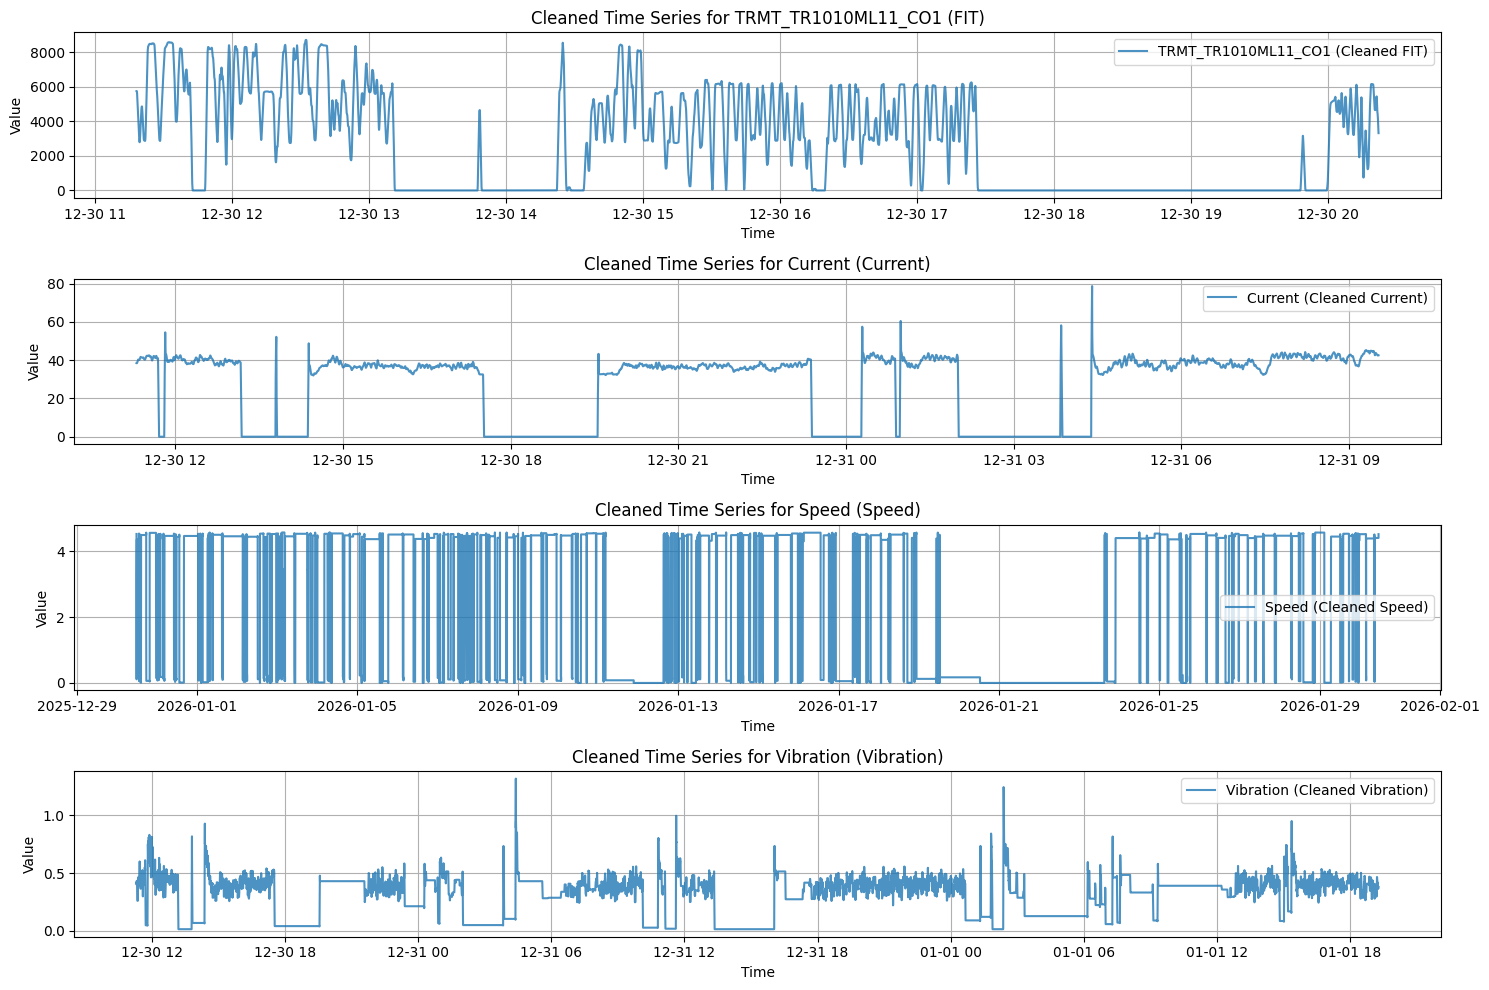

Visual inspection of cleaned time series plots for representative tags completed.


In [11]:
import pandas as pd

# 2. Handle Spikes: Replace spiked values with NaN
df.loc[df['is_spike'], 'Value'] = np.nan
print(f"Spiked values replaced with NaN. Total NaN values after spike handling: {df['Value'].isna().sum()}")

# Get the median sampling interval from previous calculations
# Assuming 'sampling_intervals' is available from prior execution
# Convert median timedelta to a string format suitable for resampling (e.g., '5s' for 5 seconds)
median_sampling_interval = sampling_intervals.median()
resample_freq = f"{int(median_sampling_interval.total_seconds())}s" # Changed 'S' to 's' to address FutureWarning

print(f"Resampling frequency set to: {resample_freq}")

# 3. Resample and Interpolate Gaps
processed_data_list = []

# Iterate through each unique Data Source
for tag_source in df['Data Source'].unique():
    # Filter data for the current tag
    temp_df = df[df['Data Source'] == tag_source].copy()

    # Set 'Time' as index and select 'Value' column for resampling
    temp_df = temp_df.set_index('Time')[['Value']]

    # Resample to consistent frequency, using mean aggregation
    temp_df_resampled = temp_df.resample(resample_freq).mean()

    # Interpolate short gaps (e.g., up to 3 consecutive NaNs)
    temp_df_interpolated = temp_df_resampled.interpolate(method='linear', limit=3)

    # Reset index and add 'Data Source', 'Tag Name', 'Tag Type' back
    temp_df_interpolated = temp_df_interpolated.reset_index()
    temp_df_interpolated['Data Source'] = tag_source

    # Add 'Tag Name' and 'Tag Type' by merging or looking up from original df
    # Get a single row to extract tag info, assuming it's consistent for the tag_source
    original_tag_info = df[df['Data Source'] == tag_source][['Tag Name', 'Tag Type']].iloc[0]
    temp_df_interpolated['Tag Name'] = original_tag_info['Tag Name']
    temp_df_interpolated['Tag Type'] = original_tag_info['Tag Type']

    processed_data_list.append(temp_df_interpolated)

# Concatenate all processed DataFrames into a single DataFrame
df_resampled = pd.concat(processed_data_list, ignore_index=True)

print("Resampling and interpolation completed.")
print("First 5 rows of df_resampled:")
print(df_resampled.head())
print(f"Total data points in df_resampled: {len(df_resampled)}")

# 4. Flag Longer Gaps/Dropouts and Fill remaining NaNs
# Sort by Data Source and Time to ensure correct flagging of gaps
df_resampled = df_resampled.sort_values(by=['Data Source', 'Time']).reset_index(drop=True)

df_resampled['is_imputed_long_gap'] = df_resampled['Value'].isna()

# Fill remaining NaNs (longer gaps) using ffill then bfill to carry observations
# Apply this within each Data Source group
df_resampled['Value'] = df_resampled.groupby('Data Source')['Value'].ffill().bfill()

print(f"\nTotal NaN values after flagging and filling long gaps: {df_resampled['Value'].isna().sum()}")
print(f"Total long gaps flagged: {df_resampled['is_imputed_long_gap'].sum()}")

# 5. Smooth Noisy Signals
# Identify noisy Tag Types. Based on common industrial sensor behavior and previous unique tags.
noisy_tag_types = ['Vibration', 'Current', 'FIT'] # Example noisy types
smoothing_window_size = window_size # Using the same window size as anomaly detection

for tag_type in noisy_tag_types:
    # Apply rolling mean smoothing to relevant tags
    # Ensure sorting by time within each data source for correct rolling mean calculation
    tag_type_mask = df_resampled['Tag Type'] == tag_type
    if tag_type_mask.any(): # Only apply if the tag type exists in the DataFrame
        df_resampled.loc[tag_type_mask, 'Value'] = df_resampled.loc[tag_type_mask].groupby('Data Source')['Value'].transform(lambda x: x.rolling(window=smoothing_window_size, min_periods=1, center=True).mean())

print(f"\nSmoothing applied to noisy signals for Tag Types: {', '.join(noisy_tag_types)}.")

# 6. Verify Cleaning
print(f"\nFinal total NaN values in 'Value' column after all preprocessing: {df_resampled['Value'].isna().sum()}")

# Select a few representative tags for visual verification after cleaning
tags_for_verification = [
    df[df['Tag Type'] == 'FIT']['Data Source'].iloc[0] if 'FIT' in df['Tag Type'].unique() else None,
    df[df['Tag Type'] == 'Current']['Data Source'].iloc[0] if 'Current' in df['Tag Type'].unique() else None,
    df[df['Tag Type'] == 'Speed']['Data Source'].iloc[0] if 'Speed' in df['Tag Type'].unique() else None,
    df[df['Tag Type'] == 'Vibration']['Data Source'].iloc[0] if 'Vibration' in df['Tag Type'].unique() else None
]
tags_for_verification = [tag for tag in tags_for_verification if tag is not None]

plt.figure(figsize=(15, 10))
for i, tag in enumerate(tags_for_verification):
    subset_df_cleaned = df_resampled[df_resampled['Data Source'] == tag].sort_values(by='Time')
    if not subset_df_cleaned.empty:
        plt.subplot(len(tags_for_verification), 1, i + 1)
        plt.plot(subset_df_cleaned['Time'], subset_df_cleaned['Value'], label=subset_df_cleaned['Tag Name'].iloc[0] + ' (Cleaned ' + subset_df_cleaned['Tag Type'].iloc[0] + ')', alpha=0.8)
        plt.title(f'Cleaned Time Series for {subset_df_cleaned['Tag Name'].iloc[0]} ({subset_df_cleaned['Tag Type'].iloc[0]})')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()

print("Visual inspection of cleaned time series plots for representative tags completed.")


## Operational State Classification with Engineering Logic

### Subtask:
Develop and apply engineering logic to classify each timestamp into 'Running', 'Idle', or 'Shutdown' operational states using throughput, motor current, and belt speed data.


**Reasoning**:
To classify operational states, I need to identify specific 'Tag Names' for throughput, motor current, and belt speed from the `df_resampled` DataFrame. I will then pivot the DataFrame to get these values aligned by time, which is necessary before applying the engineering logic thresholds.



In [12]:
import numpy as np

# Identify unique Tag Names for relevant types from df_resampled
print("Unique 'Tag Names' of FIT type:")
print(df_resampled[df_resampled['Tag Type'] == 'FIT']['Tag Name'].unique())

print("\nUnique 'Tag Names' of Current type:")
print(df_resampled[df_resampled['Tag Type'] == 'Current']['Tag Name'].unique())

print("\nUnique 'Tag Names' of Speed type:")
print(df_resampled[df_resampled['Tag Type'] == 'Speed']['Tag Name'].unique())

# Based on the unique values, select representative tags
# Assuming 'TRMT_TR1010ML11_CO1' for throughput (FIT)
# 'Current' for motor current (Tag Name is 'Current', Tag Type is 'Current')
# 'Speed' for belt speed (Tag Name is 'Speed', Tag Type is 'Speed')

throughput_tag_name = 'TRMT_TR1010ML11_CO1'
motor_current_tag_name = 'Current'
belt_speed_tag_name = 'Speed'

# Create a wide format DataFrame with only the relevant tags
# Filter for selected tags and pivot
relevant_tags_df = df_resampled[
    ((df_resampled['Tag Name'] == throughput_tag_name) & (df_resampled['Tag Type'] == 'FIT')) |
    ((df_resampled['Tag Name'] == motor_current_tag_name) & (df_resampled['Tag Type'] == 'Current')) |
    ((df_resampled['Tag Name'] == belt_speed_tag_name) & (df_resampled['Tag Type'] == 'Speed'))
].copy()

# Pivot the table to have 'Time' as index and tag values as columns
# Handling potential duplicates if a Tag Name/Type combination appears multiple times for the same timestamp
# We'll take the mean value in case of multiple entries for the same time and tag combination
relevant_tags_pivot = relevant_tags_df.groupby(['Time', 'Tag Name'])['Value'].mean().unstack()

# Ensure all three columns are present
if throughput_tag_name not in relevant_tags_pivot.columns:
    relevant_tags_pivot[throughput_tag_name] = np.nan
if motor_current_tag_name not in relevant_tags_pivot.columns:
    relevant_tags_pivot[motor_current_tag_name] = np.nan
if belt_speed_tag_name not in relevant_tags_pivot.columns:
    relevant_tags_pivot[belt_speed_tag_name] = np.nan

# Rename columns for easier access
relevant_tags_pivot = relevant_tags_pivot.rename(columns={
    throughput_tag_name: 'Throughput_Value',
    motor_current_tag_name: 'Motor_Current_Value',
    belt_speed_tag_name: 'Belt_Speed_Value'
})

# Reset index to make 'Time' a regular column again and fill any NaNs introduced by unstacking
operational_states_df = relevant_tags_pivot.reset_index()

print("\nFirst 5 rows of the pivoted DataFrame for operational state classification:")
print(operational_states_df.head())


Unique 'Tag Names' of FIT type:
['TRMT_DN3020ML10_BF1' 'TRMT_DN3020ML11_BF1' 'TRMT_DN3020ML12_BF1'
 'TRMT_TR1010ML11_CO1' 'TRMT_TR1040ML05_CO1' 'TRMT_TR1050ML11_CO1']

Unique 'Tag Names' of Current type:
['Current']

Unique 'Tag Names' of Speed type:
['Speed']

First 5 rows of the pivoted DataFrame for operational state classification:
Tag Name                Time  Motor_Current_Value  Belt_Speed_Value  \
0        2025-12-30 11:18:00            44.905555               NaN   
1        2025-12-30 11:18:05            44.912778               NaN   
2        2025-12-30 11:18:10            43.248234               NaN   
3        2025-12-30 11:18:15            43.181288               NaN   
4        2025-12-30 11:18:20            43.123142               NaN   

Tag Name  Throughput_Value  
0                      NaN  
1              5748.897705  
2              5749.690430  
3              5735.269775  
4              5626.607693  


**Reasoning**:
Now that the relevant data is in a pivoted DataFrame, I will define engineering-based thresholds for throughput, motor current, and belt speed. Using these thresholds, I will apply a set of conditional rules to classify each timestamp into 'Running', 'Idle', or 'Shutdown' states and then verify the distribution of these states.



In [13]:
import numpy as np

# Define engineering-based thresholds
# These thresholds are example values and might need to be adjusted based on expert domain knowledge.
# For industrial data, 'near zero' often means values below a small positive threshold due to sensor noise or residual activity.

throughput_shutdown_threshold = 50.0  # e.g., throughput below 50 units indicates no material flow
motor_current_shutdown_threshold = 10.0 # e.g., motor current below 10 Amps indicates motor is off
belt_speed_shutdown_threshold = 0.1   # e.g., belt speed below 0.1 m/s indicates belt is stationary

# For Idle vs. Running, the motor current and belt speed would be above shutdown, but throughput would be low/zero for idle.
# Let's assume 'Idle' implies motor/belt is active but no material is being processed.
# 'Running' implies active motor/belt AND material being processed.

# Ensure data is numeric and fill potential NaNs for threshold comparison (0 for shutdown/idle checks)
operational_states_df['Throughput_Value'] = operational_states_df['Throughput_Value'].fillna(0)
operational_states_df['Motor_Current_Value'] = operational_states_df['Motor_Current_Value'].fillna(0)
operational_states_df['Belt_Speed_Value'] = operational_states_df['Belt_Speed_Value'].fillna(0)

# Apply engineering logic for state classification
conditions = [
    (operational_states_df['Motor_Current_Value'] < motor_current_shutdown_threshold) &
    (operational_states_df['Throughput_Value'] < throughput_shutdown_threshold) &
    (operational_states_df['Belt_Speed_Value'] < belt_speed_shutdown_threshold),

    (operational_states_df['Motor_Current_Value'] >= motor_current_shutdown_threshold) &
    ((operational_states_df['Throughput_Value'] < throughput_shutdown_threshold) |
     (operational_states_df['Belt_Speed_Value'] < belt_speed_shutdown_threshold)),

    (operational_states_df['Motor_Current_Value'] >= motor_current_shutdown_threshold) &
    (operational_states_df['Throughput_Value'] >= throughput_shutdown_threshold) &
    (operational_states_df['Belt_Speed_Value'] >= belt_speed_shutdown_threshold)
]

choices = ['Shutdown', 'Idle', 'Running']

operational_states_df['Operational_State'] = np.select(conditions, choices, default='Unknown')

print("Operational state classification completed.")

print("\nDistribution of Operational States:")
print(operational_states_df['Operational_State'].value_counts())

print("\nFirst 10 rows of DataFrame with Operational_State:")
print(operational_states_df.head(10))


Operational state classification completed.

Distribution of Operational States:
Operational_State
Unknown     365295
Shutdown    159126
Idle          7863
Running       3374
Name: count, dtype: int64

First 10 rows of DataFrame with Operational_State:
Tag Name                Time  Motor_Current_Value  Belt_Speed_Value  \
0        2025-12-30 11:18:00            44.905555               0.0   
1        2025-12-30 11:18:05            44.912778               0.0   
2        2025-12-30 11:18:10            43.248234               0.0   
3        2025-12-30 11:18:15            43.181288               0.0   
4        2025-12-30 11:18:20            43.123142               0.0   
5        2025-12-30 11:18:25            43.087316               0.0   
6        2025-12-30 11:18:30            43.102615               0.0   
7        2025-12-30 11:18:35            43.129812               0.0   
8        2025-12-30 11:18:40            43.149446               0.0   
9        2025-12-30 11:18:45         

**Reasoning**:
The previous classification resulted in a large number of 'Unknown' operational states, indicating a logical gap in the conditions. To ensure all timestamps are classified into 'Running', 'Idle', or 'Shutdown' based on engineering logic, I will refine the classification rules. The new logic will prioritize 'Running', then 'Idle', and assign any remaining states (including physically inconsistent ones like throughput with the motor off) to 'Shutdown', assuming that if the motor is off, the system is fundamentally down.



In [14]:
import numpy as np

# Re-applying engineering logic with refined conditions to cover all cases

# Define engineering-based thresholds (same as before)
throughput_shutdown_threshold = 50.0
motor_current_shutdown_threshold = 10.0
belt_speed_shutdown_threshold = 0.1

# Prepare boolean series for conditions
is_motor_on = (operational_states_df['Motor_Current_Value'] >= motor_current_shutdown_threshold)
is_motor_off = (operational_states_df['Motor_Current_Value'] < motor_current_shutdown_threshold)

is_throughput_active = (operational_states_df['Throughput_Value'] >= throughput_shutdown_threshold)
is_throughput_inactive = (operational_states_df['Throughput_Value'] < throughput_shutdown_threshold)

is_belt_speed_active = (operational_states_df['Belt_Speed_Value'] >= belt_speed_shutdown_threshold)
is_belt_speed_inactive = (operational_states_df['Belt_Speed_Value'] < belt_speed_shutdown_threshold)

# Apply refined engineering logic for state classification
# The order of conditions in np.select is important: the first True condition gets assigned.
conditions_refined = [
    (is_motor_on & is_throughput_active & is_belt_speed_active), # Running
    (is_motor_on & (is_throughput_inactive | is_belt_speed_inactive)), # Idle
    (is_motor_off) # Shutdown (if motor is off, it's considered shutdown, even if other sensors show anomalies)
]

choices_refined = ['Running', 'Idle', 'Shutdown']

operational_states_df['Operational_State_Revised'] = np.select(conditions_refined, choices_refined, default='Unknown - Review Data')

print("Operational state classification with refined logic completed.")

print("\nDistribution of Operational States (Revised Logic):")
print(operational_states_df['Operational_State_Revised'].value_counts())

print("\nFirst 10 rows of DataFrame with Operational_State_Revised:")
print(operational_states_df[['Time', 'Motor_Current_Value', 'Belt_Speed_Value', 'Throughput_Value', 'Operational_State_Revised']].head(10))

# Verify that all states are covered and no 'Unknown' remains
if 'Unknown - Review Data' in operational_states_df['Operational_State_Revised'].unique():
    print("\nWARNING: Some 'Unknown - Review Data' states still exist. Further investigation needed.")
else:
    print("\nAll timestamps classified into 'Running', 'Idle', or 'Shutdown'.")


Operational state classification with refined logic completed.

Distribution of Operational States (Revised Logic):
Operational_State_Revised
Shutdown    524421
Idle          7863
Running       3374
Name: count, dtype: int64

First 10 rows of DataFrame with Operational_State_Revised:
Tag Name                Time  Motor_Current_Value  Belt_Speed_Value  \
0        2025-12-30 11:18:00            44.905555               0.0   
1        2025-12-30 11:18:05            44.912778               0.0   
2        2025-12-30 11:18:10            43.248234               0.0   
3        2025-12-30 11:18:15            43.181288               0.0   
4        2025-12-30 11:18:20            43.123142               0.0   
5        2025-12-30 11:18:25            43.087316               0.0   
6        2025-12-30 11:18:30            43.102615               0.0   
7        2025-12-30 11:18:35            43.129812               0.0   
8        2025-12-30 11:18:40            43.149446               0.0   
9    

## Production Performance Analysis and Imbalance

### Subtask:
For Import (TR11 belt scale), Export (TR11 belt scale), and Blending processes: calculate and analyze hourly and daily throughput, determining utilization percentages based on classified operational states. Identify downtime duration and frequency, differentiating between planned and unplanned events. Critically evaluate and quantify Import vs Export imbalance, considering export vessel loading behavior. Assess blending stability and consistency of blending rates, including its interaction with upstream import and downstream export. Present these metrics with production-grade visualizations, including clear legends.


**Reasoning**:
To begin the production performance analysis, I need to merge the `Operational_State_Revised` column from `operational_states_df` into the `df_resampled` DataFrame. This will allow for contextualizing throughput and other sensor data with the system's operational status. I will perform a left merge on the 'Time' column, selecting only the necessary columns from `operational_states_df` to avoid redundancy and potential issues with other columns. I'll also forward fill the `Operational_State_Revised` column to ensure states are propagated for any time points that might not have an exact match after resampling.



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Merge Operational_State_Revised into df_resampled
# Select only 'Time' and 'Operational_State_Revised' from operational_states_df
operational_states_subset = operational_states_df[['Time', 'Operational_State_Revised']]

# Perform a left merge on 'Time'
df_resampled_with_states = pd.merge(
    df_resampled,
    operational_states_subset,
    on='Time',
    how='left'
)

# Forward fill the operational states to propagate the last known state
# This is important because operational_states_df might have fewer time points
# or different time points due to its pivoting and merging logic compared to df_resampled
df_resampled_with_states['Operational_State_Revised'] = df_resampled_with_states.groupby('Data Source')['Operational_State_Revised'].ffill()

print("Merged `Operational_State_Revised` into `df_resampled` and forward-filled.")
print("First 5 rows of df_resampled_with_states with new column:")
print(df_resampled_with_states.head())
print(f"Number of NaNs in 'Operational_State_Revised' after ffill: {df_resampled_with_states['Operational_State_Revised'].isna().sum()}")

Merged `Operational_State_Revised` into `df_resampled` and forward-filled.
First 5 rows of df_resampled_with_states with new column:
                 Time     Value  \
0 2025-12-30 11:18:15  0.417633   
1 2025-12-30 11:18:20  0.416689   
2 2025-12-30 11:18:25  0.410737   
3 2025-12-30 11:18:30  0.401446   
4 2025-12-30 11:18:35  0.400011   

                                         Data Source   Tag Name   Tag Type  \
0  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...  Vibration  Vibration   
1  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...  Vibration  Vibration   
2  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...  Vibration  Vibration   
3  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...  Vibration  Vibration   
4  \\PIAF-MALAYSIA\DB_Operational Data\Vale (Asse...  Vibration  Vibration   

   is_imputed_long_gap Operational_State_Revised  
0                False                      Idle  
1                False                      Idle  
2                False            

**Reasoning**:
Now that the operational states are merged, I will filter the data for the designated 'Import' throughput tag and calculate its total hourly and daily throughput by resampling and summing the 'Value' column.



In [ ]:
import_throughput_tag_name = 'TRMT_TR1010ML11_CO1'
import_throughput_tag_type = 'FIT'

# Filter for the Import throughput tag
df_import_throughput = df_resampled_with_states[
    (df_resampled_with_states['Tag Name'] == import_throughput_tag_name) &
    (df_resampled_with_states['Tag Type'] == import_throughput_tag_type)
].copy()

# Set 'Time' as index for resampling
df_import_throughput = df_import_throughput.set_index('Time')

# Calculate hourly throughput
hourly_import_throughput = df_import_throughput['Value'].resample('H').sum().reset_index()
hourly_import_throughput.rename(columns={'Value': 'Hourly_Import_Throughput'}, inplace=True)

# Calculate daily throughput
daily_import_throughput = df_import_throughput['Value'].resample('D').sum().reset_index()
daily_import_throughput.rename(columns={'Value': 'Daily_Import_Throughput'}, inplace=True)

print(f"Calculated hourly and daily throughput for Import tag: {import_throughput_tag_name}.")
print("\nFirst 5 rows of Hourly Import Throughput:")
print(hourly_import_throughput.head())
print("\nFirst 5 rows of Daily Import Throughput:")
print(daily_import_throughput.head())

Calculated hourly and daily throughput for Import tag: TRMT_TR1010ML11_CO1.

First 5 rows of Hourly Import Throughput:
                 Time  Hourly_Import_Throughput
0 2025-12-30 11:00:00              2.648231e+06
1 2025-12-30 12:00:00              4.211023e+06
2 2025-12-30 13:00:00              7.413761e+05
3 2025-12-30 14:00:00              1.802029e+06
4 2025-12-30 15:00:00              2.919668e+06

First 5 rows of Daily Import Throughput:
        Time  Daily_Import_Throughput
0 2025-12-30             1.732386e+07


/tmp/ipython-input-2729689083.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_import_throughput = df_import_throughput['Value'].resample('H').sum().reset_index()
